In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [2]:
sys.path.append('../')
import compute_preprocessing_mean_zero as compute_preprocessing

In [3]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [4]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [5]:
import tensorflow as tf

In [6]:
import pugna.layers
import pugna.activations

In [7]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [8]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params



In [9]:
mfiles = sorted(glob.glob("results*7/model*"))
print(mfiles)

models = OrderedDict()
for mfile in mfiles:
    key = mfile.split('/')[0]
    models[key] = tf.keras.models.load_model(mfile,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

['results_7/model.h5']


In [10]:
models.keys()

odict_keys(['results_7'])

In [11]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/july2021-mscale-zero-mean/"

In [12]:
times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp(data_dir=data_dir)

# times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp_1e3(data_dir=data_dir)

# times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_phase(data_dir=data_dir)

In [13]:
coords.shape

(3, 500)

In [14]:
ys.shape

(500, 1099)

In [15]:
times

array([-499.5053452, -499.0053452, -498.5053452, ...,   48.4946548,
         48.9946548,   49.4946548])

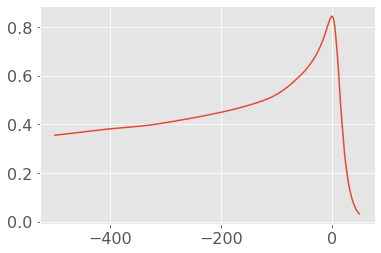

In [16]:
plt.figure()
plt.plot(times, ys[0])

In [17]:
def compare_models(index, ys_raw, preprocessing_params, coords, times_scaled, times, models, ylim=None, xlim=None):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    
    title = f"q = {q}, chi1 = {chi1}, theta1 = {theta1}"
    
    Xhat = compute_model_input(times_scaled, q, chi1, theta1)
    yhats = OrderedDict()
    for k, v in models.items():
        yhat = models[k].predict(Xhat).T
        
        yhats[k] = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
#         yhats[k] = yhat[0]
        
        
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(times, ys_raw[index], label='data')
    for k, v in yhats.items():
        plt.plot(times, v, label=k, ls='--')
    if xlim:
        plt.xlim(*xlim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.yscale('log')
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(2, 1, 2)
    for k, v in yhats.items():
#         plt.plot(times, 100*np.abs((v-ys_raw[index])/ys_raw[index]), label=f"% (data-{k})")
        plt.plot(times, (v-ys_raw[index]), label=f"% (data-{k})")
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
#     plt.xlim(-200, 50)
#     plt.xlim(-10, 50)
#     plt.ylim(-10, 10)
#     plt.yscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [18]:
# np.where((coords[1] > 0.98) & (coords[2] > 1.3) & (coords[2] < 1.7))
np.where((coords[0] > 2.9) & (coords[1] > 0.4) & (coords[2] > 1.3) & (coords[2] < 1.7))

(array([444]),)

In [19]:
# np.where((coords[1] > 0.6) & (coords[2] > 1.3) & (coords[2] < 1.6))

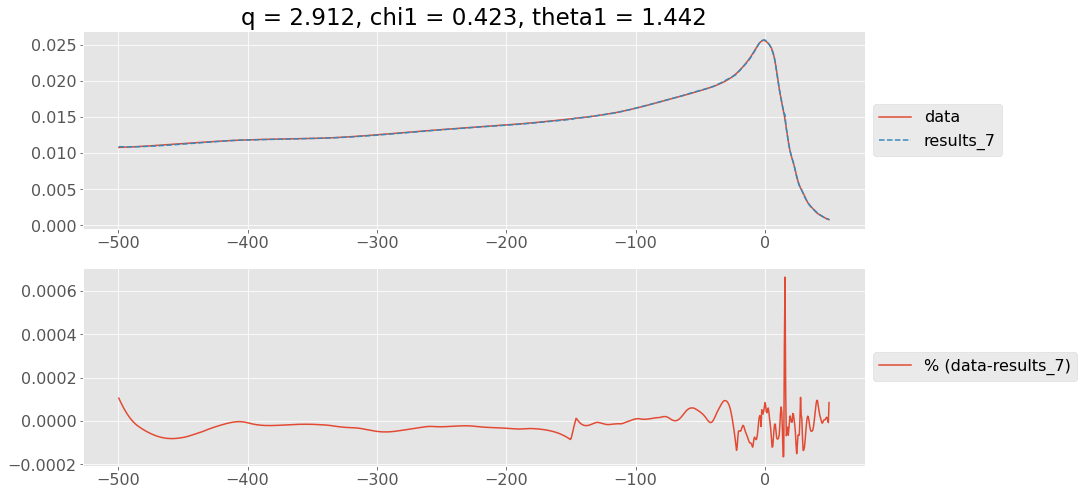

In [20]:
compare_models(index=444, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

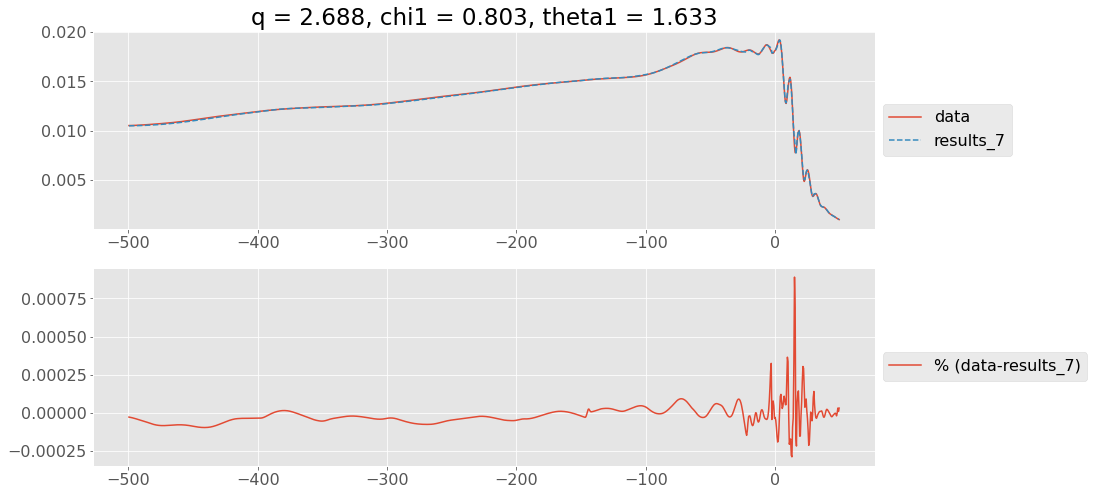

In [21]:
compare_models(index=239, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [22]:
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models, ylim=(-0.1,0.1))
# compare_models(index=361, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models={'005':models['005']})

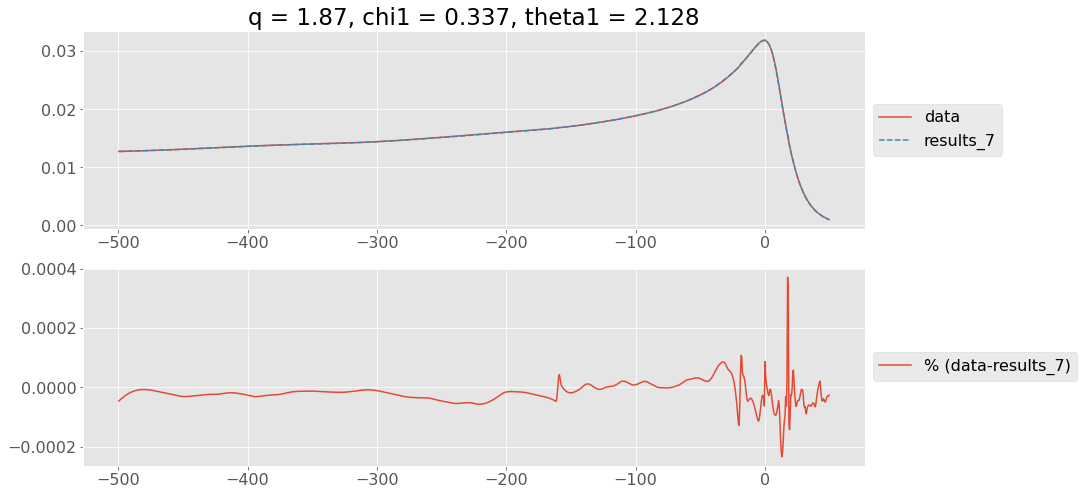

In [23]:
compare_models(index=10, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [24]:
# Xhat = convert_input_for_ann(times_scaled, *coords[:, :10])
# # Xhat = convert_input_for_ann(times_scaled, *coords)
# yhat = models['008'].predict(Xhat).T

In [25]:
# yhat.shape

In [26]:
def compute_errors(ys_raw, preprocessing_params, coords, times_scaled, times, models):
    
    n_cases = coords.shape[1]
#     max_loop = 1000
    max_loop = n_cases
    
    yhats = OrderedDict()
    errors = OrderedDict()
    for k, v in models.items():
        
        if os.path.exists(f"errors_{k}.npy"):
            print("ALREADY CALCULATED LOADING DATA")
            errors[k] = np.load(f"errors_{k}.npy")
            continue
        
        print(f"working model: {k}")
        yhats[k] = np.zeros(shape=(n_cases, times_scaled.shape[0]))
        errors[k] = np.zeros(shape=(max_loop))

#         for index in tqdm(range(n_cases)):
        for index in tqdm(range(max_loop)):

            q = coords[0,index]
            chi1 = coords[1,index]
            theta1 = coords[2,index]

            Xhat = compute_model_input(times_scaled, q, chi1, theta1)
        
            yhat = models[k].predict(Xhat).T
            tt = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
            yhats[k][index] = tt
            
#             errors[k][index] = np.max(100*(ys_raw[index]-yhats[k][index])/ys_raw[index])
            errors[k][index] = np.max(np.abs(ys_raw[index]-yhats[k][index]))
            
        print("SAVING")
        np.save(f"errors_{k}.npy", errors[k])
        
    return errors

In [27]:
%%time
errors = compute_errors(ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

  0%|          | 1/500 [00:00<01:28,  5.62it/s]

working model: results_7


100%|██████████| 500/500 [01:22<00:00,  6.08it/s]


SAVING
CPU times: user 2min 2s, sys: 17.7 s, total: 2min 20s
Wall time: 1min 22s


In [28]:
# errors['008'].shape

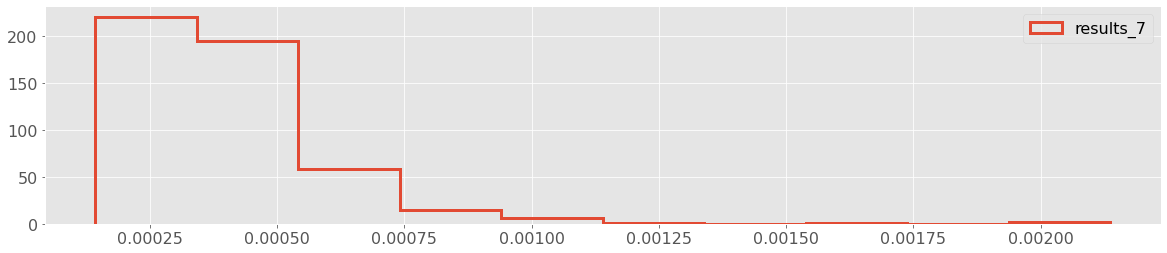

In [29]:
plt.figure(figsize=(20, 4))
for i,(k,v) in enumerate(errors.items()):
    plt.subplot(1, len(errors.keys()), i+1)
    plt.hist(np.abs(v), label=k, histtype='step', linewidth=3);
#     , density=True
    plt.legend()
# plt.xlim(0, 100)

In [30]:
max_idx = {}
for i,(k,v) in enumerate(errors.items()):
    max_value = np.max(np.abs(v))
    print(f"{k}: {max_value}")
    max_idx[k] = np.where(np.abs(v) == max_value)

results_7: 0.0021359886754939435


In [31]:
max_idx

{'results_7': (array([481]),)}

Text(0, 0.5, '$\\theta_1$')

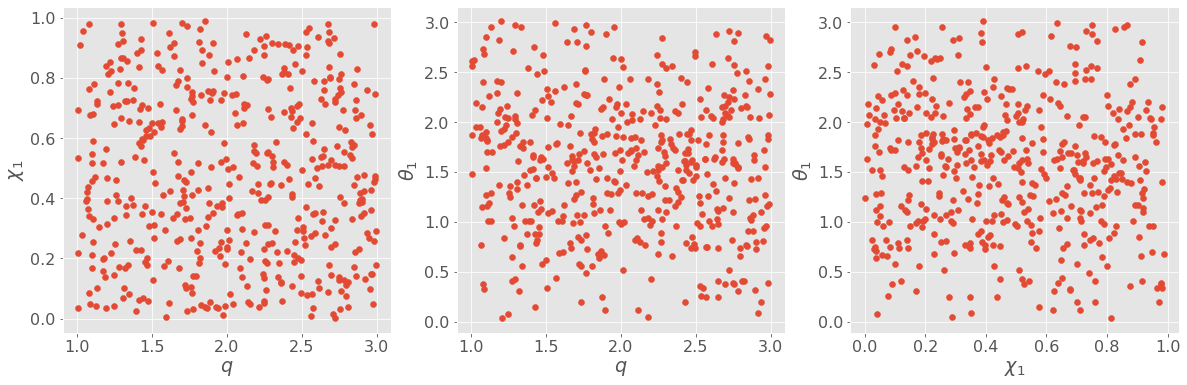

In [32]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1])
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2])
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2])
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [33]:
errors.keys()

odict_keys(['results_7'])

Text(0, 0.5, '$\\theta_1$')

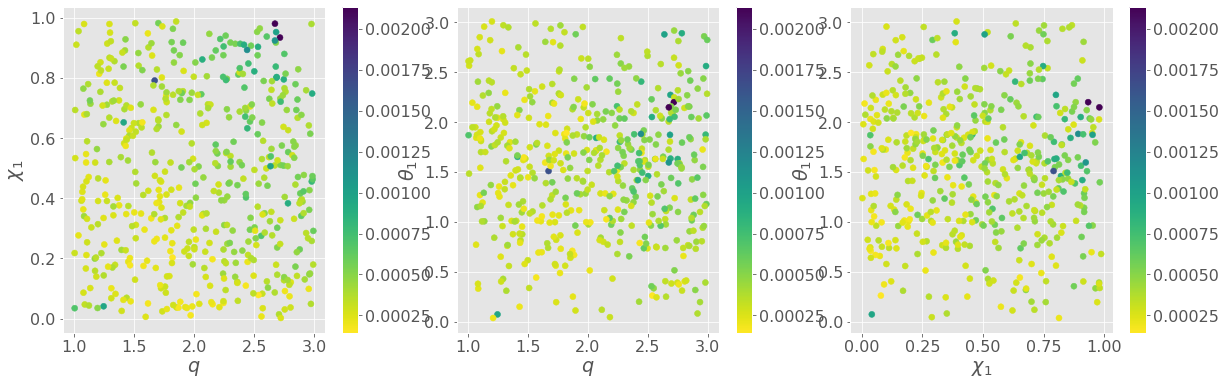

In [35]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1], c=errors['results_7'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2], c=errors['results_7'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2], c=errors['results_7'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')

In [36]:
worst_cases_values = np.flip(np.sort(np.abs(errors['results_7'])))[:10]
# worst_cases_values = np.flip(np.sort(np.abs(errors['results_7'])))[-10:]
# worst_cases_values = np.flip(np.sort(np.abs(errors['results_7'])))[-100:-90]
worst_cases_idx = np.array([np.where(np.abs(errors['results_7']) == w_c)[0][0] for w_c in worst_cases_values])

In [37]:
worst_cases_values

array([0.00213599, 0.0021218 , 0.00164488, 0.00116057, 0.00109835,
       0.0010042 , 0.00098461, 0.00096446, 0.00096438, 0.00094966])

In [38]:
worst_cases_idx

array([481, 117, 155, 304, 250, 423, 393, 175,  43,  66])

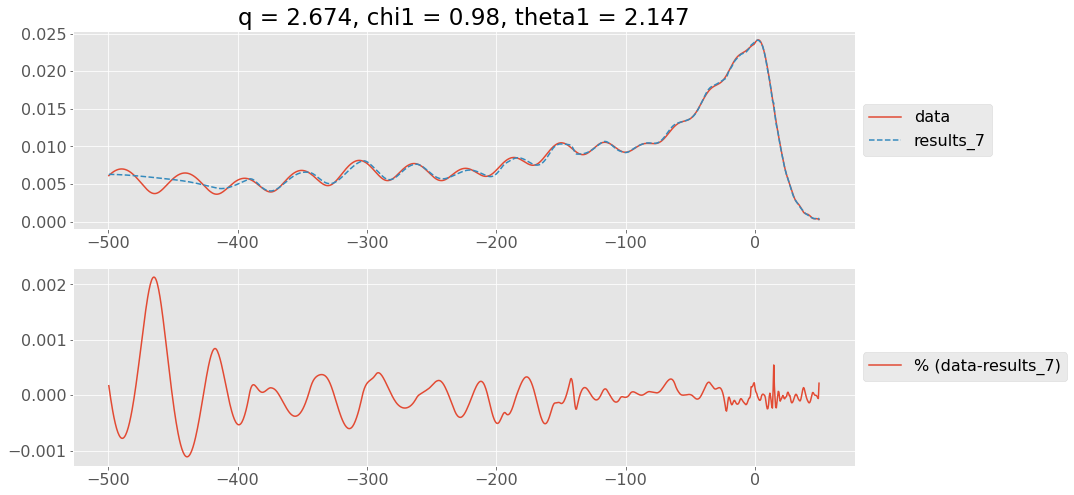

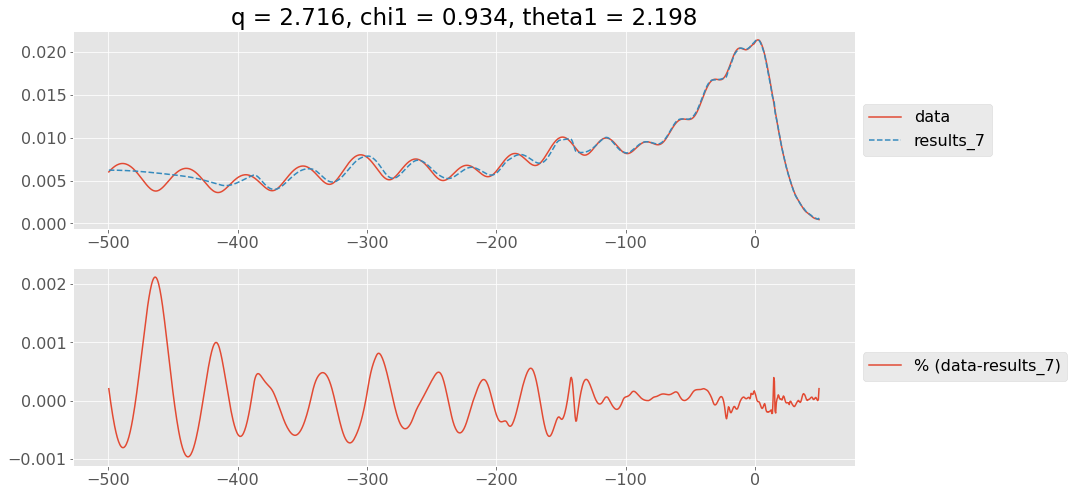

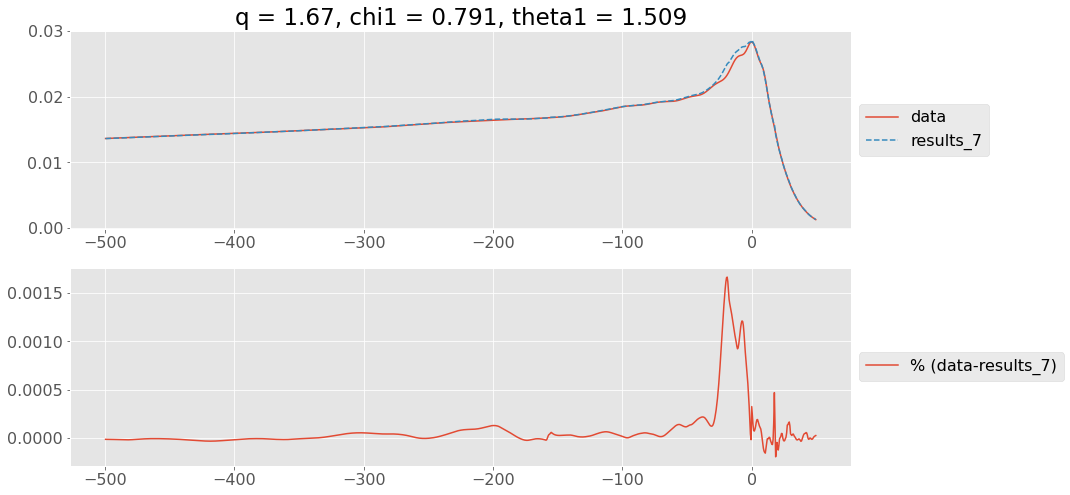

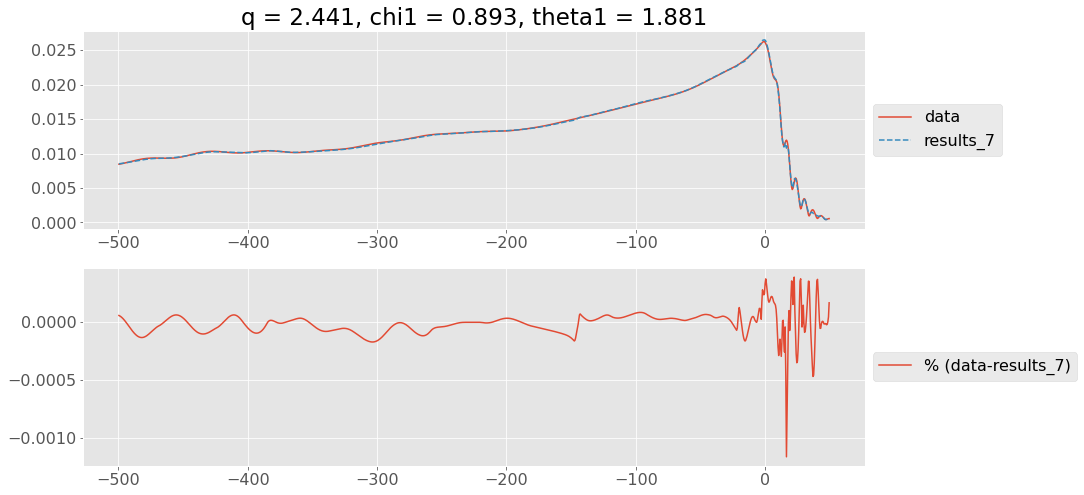

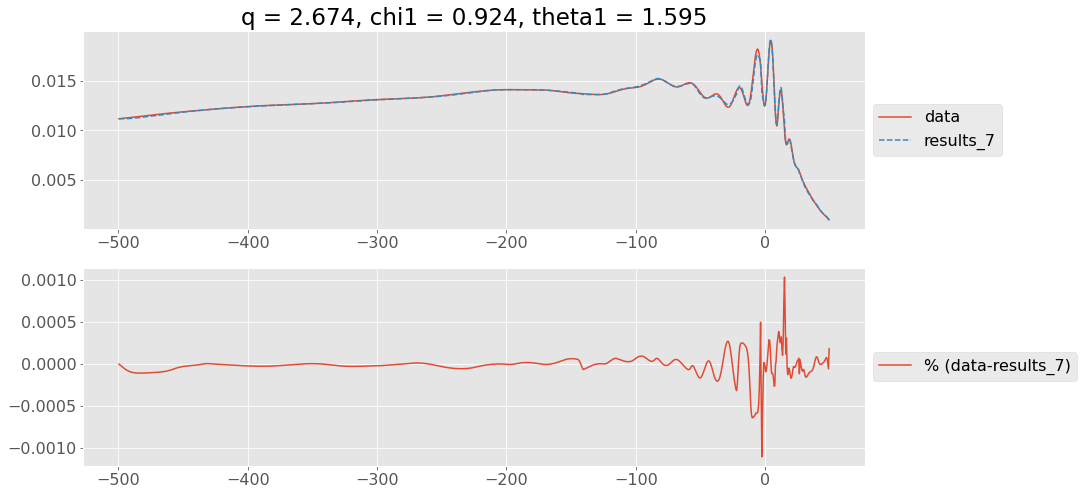

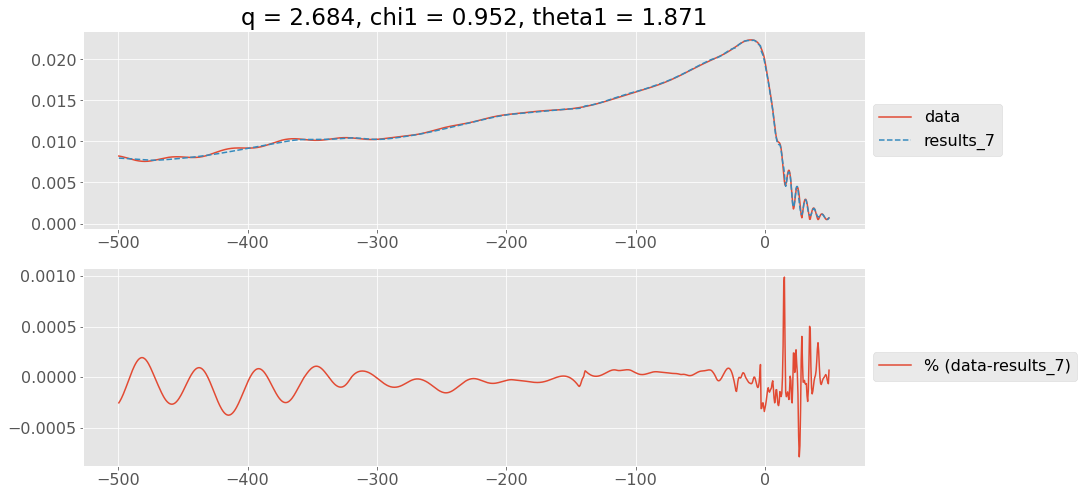

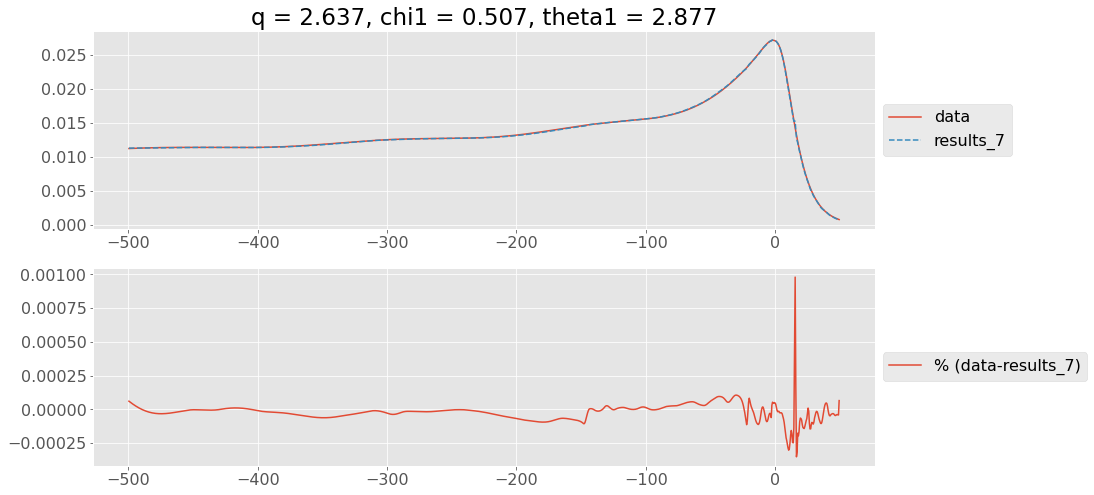

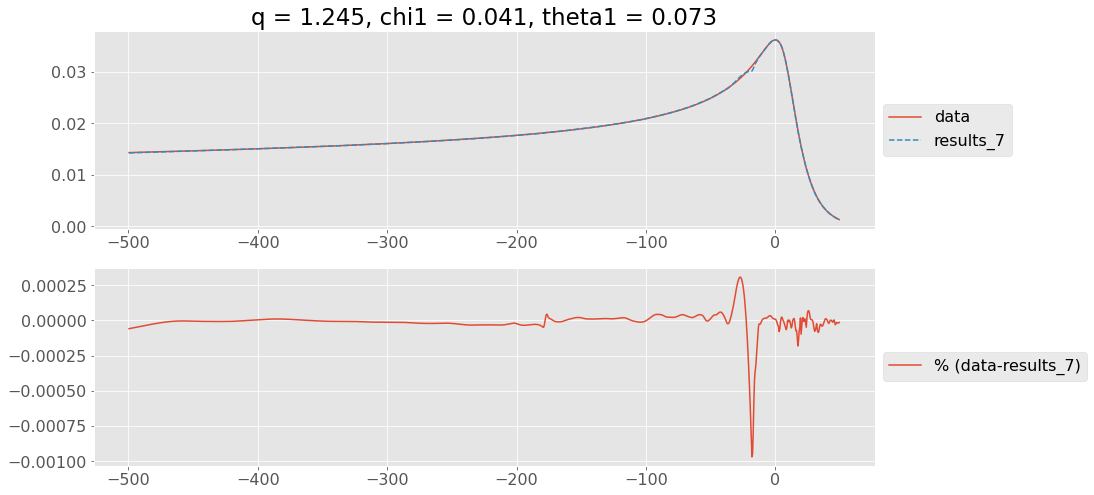

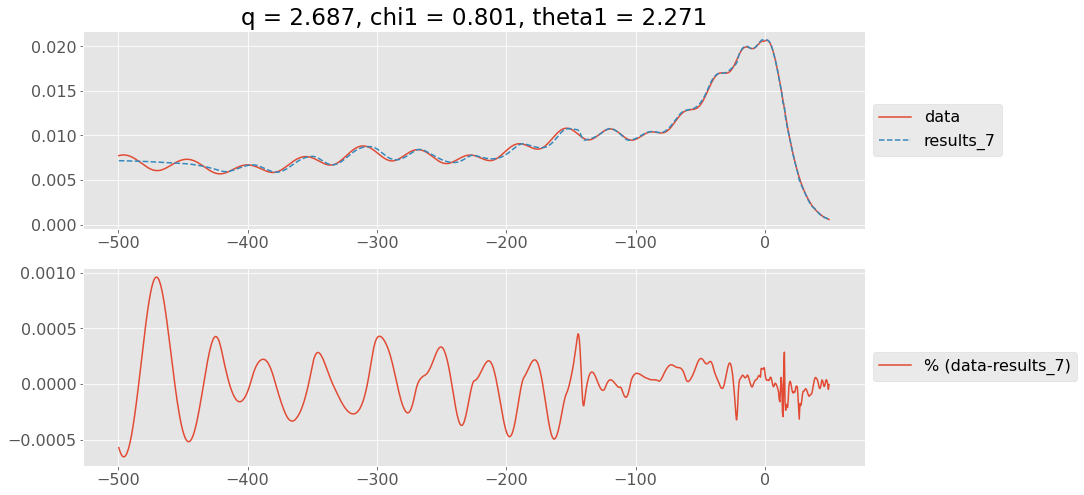

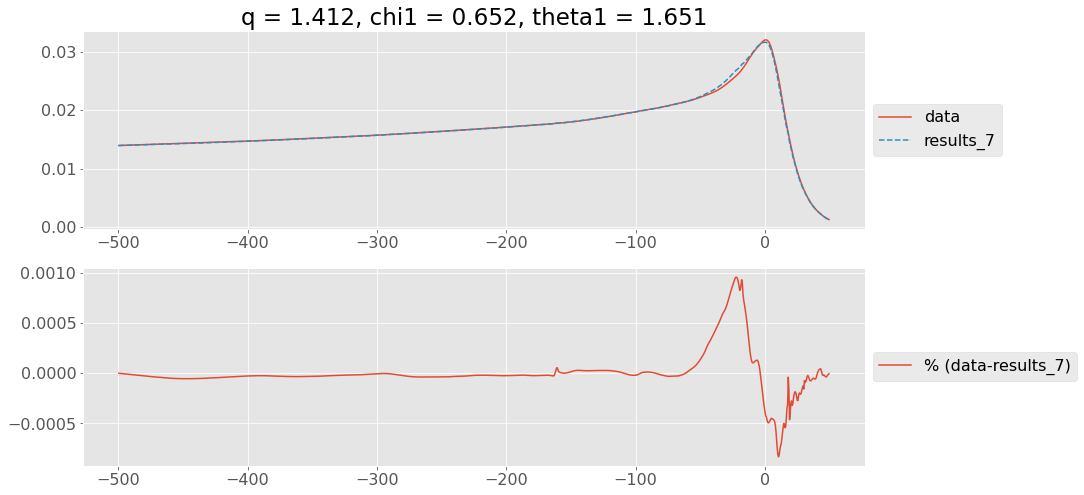

In [39]:
for index in worst_cases_idx:
    compare_models(index=index, ys_raw=ys_raw, preprocessing_params=ys_processing_params,
                   coords=coords, times_scaled=times_scaled, times=times, models=models)

# try batching

In [ ]:
q = 1
chi1 = 0.2
theta1 = 1.3
Xhat1 = compute_model_input(times_scaled, q, chi1, theta1)
# Xhat1 = np.expand_dims(Xhat1, axis=0)


q = 2.3
chi1 = 0.9
theta1 = 1.78
Xhat2 = compute_model_input(times_scaled, q, chi1, theta1)
# Xhat2 = np.expand_dims(Xhat2, axis=0)

In [ ]:
Xhat1.shape

In [ ]:
Xhat2.shape

In [ ]:
Xhat_batch = np.stack((Xhat1, Xhat2), axis=0)

In [ ]:
Xhat_batch.shape

In [ ]:
Xhat_batch[0].shape

In [ ]:
yhat = models['results_2'].predict(Xhat_batch[0]).T

In [ ]:
yhat.shape

In [ ]:
# yhat = models['002'].predict(Xhat_batch).T

In [ ]:
Xhat_batch_v2 = np.concatenate((Xhat1, Xhat2), axis=0)

In [ ]:
Xhat_batch_v2.shape

In [ ]:
yhat = models['results_2'].predict(Xhat_batch_v2).T

In [ ]:
yhat.shape

In [ ]:
yhat_re = yhat.reshape(2, 1099)

In [ ]:
plt.figure()
plt.plot(yhat[0], label='both', ls='--')
plt.plot(yhat_re[0], label='0')
plt.plot(yhat_re[1], label='1')
plt.legend()

In [ ]:
plt.figure()
plt.plot(np.concatenate((times,times)), yhat[0], label='both', ls='--', lw=3)
plt.plot(times, yhat_re[0], label='0')
plt.plot(times, yhat_re[1], label='1')
plt.legend()